In [1]:
!tail -2 /local/fever-common/data/fever-data/train.jsonl

tail: cannot open '/local/fever-common/data/fever-data/train.jsonl' for reading: No such file or directory


In [1]:
!tail -2 data/data/fever-data/train.jsonl

{"id": 13114, "verifiable": "VERIFIABLE", "label": "SUPPORTS", "claim": "J. R. R. Tolkien created Gimli.", "evidence": [[[28359, 34669, "Gimli_-LRB-Middle-earth-RRB-", 0]], [[28359, 34670, "Gimli_-LRB-Middle-earth-RRB-", 1]]]}
{"id": 152180, "verifiable": "VERIFIABLE", "label": "SUPPORTS", "claim": "Susan Sarandon is an award winner.", "evidence": [[[176133, 189101, "Susan_Sarandon", 1]], [[176133, 189102, "Susan_Sarandon", 2]], [[176133, 189103, "Susan_Sarandon", 8]]]}


In [13]:
!mkdir -p working/data/training

In [2]:
ls working/data/training/

paper_dev.ns.pages.p5.jsonl  train.ns.pages.p5.jsonl  train.pages.p5.jsonl


In [26]:
!pip install -r requirements.txt

     |████████████████████████████████| 681 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 1.9 MB/s eta 0:00:011
     |████████████████████████████████| 124 kB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.0 MB 11.0 MB/s eta 0:00:01    |████████████████████▎           | 8.2 MB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 259 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.1 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 804.1 MB 15 kB/s  eta 0:00:011    |██▍                             | 60.9 MB 10.3 MB/s eta 0:01:13     |██▌                             | 62.5 MB 10.3 MB/s eta 0:01:12     |██▋                             | 64.9 MB 10.3 MB/s eta 0:01:12     |███▏                            | 79.4 MB 6.7 MB/s eta 0:01:48     |███▏                            | 79.8 MB 6.7 MB/s eta 0:01:48     |███▊                            | 

In [278]:

class LabelSchema:
    def __init__(self,labels):
        self.labels = {self.preprocess(val):idx for idx,val in enumerate(labels)}
        self.idx = {idx:self.preprocess(val) for idx,val in enumerate(labels)}

    def get_id(self,label):
        if self.preprocess(label) in self.labels:
            return self.labels[self.preprocess(label)]
        return None

    def preprocess(self,item):
        return item.lower()

class FEVERLabelSchema(LabelSchema):
    def __init__(self):
        super().__init__(["supports", "refutes", "not enough info"])

def nltk_tokenizer(text):
    return " ".join(word_tokenize(text))

class training_line_formatter():
        
    def format(self, lines):
        formatted = []
        for line in tqdm(lines):
            fl = self.format_line(line)
            if fl is not None:
                if isinstance(fl,list):
                    formatted.extend(fl)
                else:
                    formatted.append(fl)
        return formatted

    def format_line(self, line):
        label_schema = FEVERLabelSchema()
        # get the label, i.e. SUPPORTS etc.
        annotation = line["label"]
        if annotation is None:
            annotation = line["verifiable"]
        pages = []
        # did we get the closest sentences to the claim text? is this the sentence or the line number from the doc text?
        if 'predicted_sentences' in line:
            pages.extend([(ev[0], ev[1]) for ev in line["predicted_sentences"]])
        elif 'predicted_pages' in line:
            pages.extend([(ev[0], -1) for ev in line["predicted_pages"]])
        else:
            # these are the human annotated evidence available in the original training file
            for evidence_group in line["evidence"]:
                pages.extend([(ev[2], ev[3]) for ev in evidence_group])
        return {"claim": line["claim"], "evidence": pages, "label": label_schema.get_id(annotation),
                "label_text": annotation}

In [279]:
class Reader:
    def __init__(self,encoding="utf-8"):
        self.enc = encoding

    def read(self,file):
        with open(file,"r",encoding = self.enc) as f:
            return self.process(f)

    def process(self,f):
        pass

class JSONLineReader(Reader):
    def process(self,fp):
        data = []
        for line in tqdm(fp.readlines()):
            data.append(json.loads(line.strip()))
        return data

In [280]:
import json
from tqdm import tqdm
jlr = JSONLineReader()
split = 'train'
working_dir = 'working/data/'
k = 5
training_data_file = working_dir + "training/{0}.ns.pages.p{1}.jsonl".format(split, k)
data = jlr.read(training_data_file)

100%|██████████| 145449/145449 [00:01<00:00, 79429.47it/s] 


In [281]:
formatter = training_line_formatter()
formatted_train_data = formatter.format(data)

100%|██████████| 145449/145449 [00:01<00:00, 133927.68it/s]


In [282]:
formatted_train_data[:2]

[{'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [('Nikolaj_Coster-Waldau', 7), ('Fox_Broadcasting_Company', 0)],
  'label': 0,
  'label_text': 'SUPPORTS'},
 {'claim': 'Roman Atwood is a content creator.',
  'evidence': [('Roman_Atwood', 1), ('Roman_Atwood', 3)],
  'label': 0,
  'label_text': 'SUPPORTS'}]

In [7]:
[d for d in formatted_train_data if d['label_text'] == 'NOT ENOUGH INFO'][:5]

[{'claim': 'System of a Down briefly disbanded in limbo.',
  'evidence': [('In_Limbo', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Beautiful reached number two on the Billboard Hot 100 in 2003.',
  'evidence': [('Ricky_Martin_singles_discography', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Neal Schon was named in 1954.',
  'evidence': [('Double_Eclipse', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'John Wick: Chapter 2 was theatrically released in the Oregon.',
  'evidence': [('John_Wick_-LRB-disambiguation-RRB-', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Afghanistan is the source of the Kushan dynasty.',
  'evidence': [('Kanishka_-LRB-name-RRB-', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'}]

#### RANDOMS, NEARESTP approach
TODO: Need to sample sentences for the 'not enough info' class, either sample them randomly from the nearest matching document, or sample random sentences from the Wiki corpus.

In [4]:
ls working/data/training

paper_dev.ns.pages.p5.jsonl            train.ns.pages.p5.jsonl
paper_test.ns.pages.p5.jsonl           train.pages.p5.jsonl
paper_test_pipeline.ns.pages.p5.jsonl


In [283]:
import json
from tqdm import tqdm
jlr = JSONLineReader()
split = 'paper_dev'
working_dir = 'working/data/'
k = 5
dev_data_file = working_dir + "training/{0}.ns.pages.p{1}.jsonl".format(split, k)
dev_data = jlr.read(dev_data_file)

formatter = training_line_formatter()
formatted_dev_data = formatter.format(dev_data)

dev_data_formatted = []
dev_data_formatted.extend(filter(lambda record: record is not None, formatted_dev_data))
dev_data_formatted[:2]

100%|██████████| 9999/9999 [00:00<00:00, 202583.55it/s]


[{'claim': 'Colin Kaepernick became a starting quarterback during the 49ers 63rd season in the National Football League.',
  'evidence': [('Colin_Kaepernick', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Tilda Swinton is a vegan.',
  'evidence': [('Swinton_-LRB-surname-RRB-', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'}]

#### Prepare the test data

In [284]:
import json
from tqdm import tqdm
jlr = JSONLineReader()
split = 'paper_test_pipeline'
working_dir = 'working/data/'
k = 5
test_data_file = working_dir + "training/{0}.ns.pages.p{1}.jsonl".format(split, k)
test_data = jlr.read(test_data_file)

formatter = training_line_formatter()
formatted_test_data = formatter.format(test_data)

test_data_formatted = []
test_data_formatted.extend(filter(lambda record: record is not None, formatted_test_data))
test_data_formatted[:3]

100%|██████████| 9999/9999 [00:00<00:00, 186650.37it/s]


[{'claim': 'Grease had bad reviews.',
  'evidence': [('Grease_gun_-LRB-tool-RRB-', -1),
   ('Grease_gun_-LRB-tool-RRB-', -2),
   ('Nasal_sebum', -2),
   ('Grease', -2),
   ('Thermal_interface_material', -2)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Ukrainian Soviet Socialist Republic was a founding participant of the UN.',
  'evidence': [('Emblem_of_the_Ukrainian_Soviet_Socialist_Republic', -2),
   ('Flag_of_the_Moldavian_Autonomous_Soviet_Socialist_Republic', -2),
   ('Flag_of_the_Moldavian_Autonomous_Soviet_Socialist_Republic', -2),
   ('Ukrainian_Republic', -2),
   ('List_of_Presidents_of_Ukraine', -2),
   ('United_Nations_General_Assembly_Resolution_377', -2),
   ('United_Nations_General_Assembly_Resolution_377', -2)],
  'label': 0,
  'label_text': 'SUPPORTS'},
 {'claim': '2 Hearts is a musical composition by Minogue.',
  'evidence': [('2_Hearts_-LRB-Kylie_Minogue_song-RRB-', -2),
   ('Kylie_Minogue_singles_discography', -2),
   ('Kylie_Minogue', -2),
   ('X_-

#### Build the tokenizer

In [186]:
import random
import os

class SimpleRandom():
    instance = None

    def __init__(self,seed):
        self.seed = seed
        self.random = random.Random(seed)

    def next_rand(self,a,b):
        return self.random.randint(a,b)

    @staticmethod
    def get_instance():
        if SimpleRandom.instance is None:
            SimpleRandom.instance = SimpleRandom(SimpleRandom.get_seed())
        return SimpleRandom.instance

    @staticmethod
    def get_seed():
        return int(os.getenv("RANDOM_SEED", 12459))

    @staticmethod
    def set_seeds():

        torch.manual_seed(SimpleRandom.get_seed())
        if gpu():
            torch.cuda.manual_seed_all(SimpleRandom.get_seed())
        np.random.seed(SimpleRandom.get_seed())
        random.seed(SimpleRandom.get_seed())

In [285]:
from drqa.retriever import DocDB, utils
class FeverDocDB(DocDB):

    def __init__(self,path=None):
        super().__init__(path)

    def get_doc_lines(self, doc_id):
        """Fetch the raw text of the doc for 'doc_id'."""
        cursor = self.connection.cursor()
        cursor.execute(
            "SELECT lines FROM documents WHERE id = ?",
            (utils.normalize(doc_id),)
        )
        result = cursor.fetchone()
        cursor.close()
        return result if result is None else result[0]

    def get_non_empty_doc_ids(self):
        """Fetch all ids of docs stored in the db."""
        cursor = self.connection.cursor()
        cursor.execute("SELECT id FROM documents WHERE length(trim(text)) > 0")
        results = [r[0] for r in cursor.fetchall()]
        cursor.close()
        return results
#database_path = '/local/fever-common/data/fever/fever.db'
database_path = 'data/data/fever/fever.db'
database = FeverDocDB(database_path)

In [286]:
ename = "evidence"
def claims(data):
    return [datum["claim"] for datum in data]
def body_ids(data):
    return [[d[0] for d in datum[ename] ] for datum in data]
def flatten(l):
    return [item for sublist in l for item in sublist]
def bodies(data):
    return [database.get_doc_text(id) for id in set(flatten(body_ids(data)))]

def texts(data):
    return [" ".join(set(instance)) for instance in body_lines(data)]

def body_lines(data):
    return [[get_doc_line(d[0],d[1]) for d in datum[ename] ] for datum in data]

def get_doc_line(doc,line):
    lines = database.get_doc_lines(doc)
    ### if this is from annotated evidences
    if line > -1:
        return lines.split("\n")[line].split("\t")[1] #get all the lines from the document and match with the line ids that were annotated as evidence by the human annotators
    elif line <= -2:
        #TODO: nearest 5 sentences from the document
        non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
        return non_empty_lines[SimpleRandom.get_instance().next_rand(0,len(non_empty_lines)-1)]
    else: ### if this is from not enough info evidences, NearestP method, to sample "a" single sentence randomly from the nearest page match
        non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
        return non_empty_lines[SimpleRandom.get_instance().next_rand(0,len(non_empty_lines)-1)]

In [24]:
lines = database.get_doc_lines('John_Wick_-LRB-disambiguation-RRB-')
non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
non_empty_lines

['John Wick may refer to :',
 'John Wick franchise :',
 "John Wick : chapter 1 -LRB- 2014 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''",
 'John Wick : Original Motion Picture Soundtrack -LRB- 2014 album -RRB-',
 "John Wick : Chapter 2 -LRB- 2017 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''",
 'John Wick -LRB- game designer -RRB- American RPG designer',
 'John Wick Presents -LRB- company -RRB- American game company',
 'John Wick -LRB- whistleblower -RRB- , former Special Air Service major who was a source revealing a 2009 political scandal , see United Kingdom parliamentary expenses scandal',
 'John F. Wick , organist and founder of the Wicks Organ Company']

In [13]:
from drqascripts.retriever.build_tfidf_lines import OnlineTfidfDocRanker

In [20]:
import math
class RankArgs:
    def __init__(self):
        self.ngram = 2
        self.hash_size = int(math.pow(2,24))
        self.tokenizer = "simple"
        self.num_workers = None
args = RankArgs()


In [50]:
data = [{'claim':'John Wick: Chapter 2 was theatrically released in the Oregon.',
        'docs': ['John_Wick_-LRB-disambiguation-RRB-']},
       {'claim':'John Wick: Chapter 2 was theatrically released in the Oregon.',
        'docs': ['John_Wick_-LRB-disambiguation-RRB-']},
       {'claim':'John Wick: Chapter 2 was theatrically released in the Oregon.',
        'docs': ['John_Wick_-LRB-disambiguation-RRB-']},
       {'claim':'John Wick: Chapter 2 was theatrically released in the Oregon.',
        'docs': ['John_Wick_-LRB-disambiguation-RRB-']}]

In [54]:
import numpy as np

import math
class RankArgs:
    def __init__(self):
        self.ngram = 2
        self.hash_size = int(math.pow(2,24))
        self.tokenizer = "simple"
        self.num_workers = None
args = RankArgs()


def get_doc_line(doc,line):
    lines = database.get_doc_lines(doc)
    ### if this is from annotated evidences
    if line > -1:
        return lines.split("\n")[line].split("\t")[1] #get all the lines from the document and match with the line ids that were annotated as evidence by the human annotators
    elif line <= -2:
        #TODO: nearest 5 sentences from the document
        non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
        return non_empty_lines[SimpleRandom.get_instance().next_rand(0,len(non_empty_lines)-1)]
    else: ### if this is from not enough info evidences, NearestP method, to sample "a" single sentence randomly from the nearest page match
        non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
        return non_empty_lines[SimpleRandom.get_instance().next_rand(0,len(non_empty_lines)-1)]
    
def tfidf_claim(data):
    docs = data['docs']
    claim = data['claim']
#     print(docs)
    ranked_lines = []
    for doc in docs:
        lines = database.get_doc_lines(doc)
        non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
        tfidf = OnlineTfidfDocRanker(args,[line for line in non_empty_lines],None)
        line_ids,scores = tfidf.closest_docs(claim,5)
#         print(line_ids)
#         print(non_empty_lines)
        ranked_lines.extend(np.array(non_empty_lines)[line_ids])
    return ranked_lines

In [ ]:
from multiprocessing.pool import ThreadPool

In [57]:
%%time
tfidf_claim(data[0])

CPU times: user 1.36 s, sys: 820 ms, total: 2.17 s
Wall time: 2.17 s


["John Wick : Chapter 2 -LRB- 2017 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''",
 "John Wick : chapter 1 -LRB- 2014 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''"]

In [55]:
def find_nearest_lines(data):
    with ThreadPool(4) as threads:
        results = threads.map(tfidf_claim, data)
    return results

In [56]:
%%time
find_nearest_lines(data)

CPU times: user 9.64 s, sys: 4.67 s, total: 14.3 s
Wall time: 3.71 s


[["John Wick : Chapter 2 -LRB- 2017 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''",
  "John Wick : chapter 1 -LRB- 2014 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''"],
 ["John Wick : Chapter 2 -LRB- 2017 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''",
  "John Wick : chapter 1 -LRB- 2014 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''"],
 ["John Wick : Chapter 2 -LRB- 2017 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''",
  "John Wick : chapter 1 -LRB- 2014 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''"],
 ["John Wick : Chapter 2 -LRB- 2017 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''",
  "John Wick : chapter 1 -LRB- 2014 film -RRB- action film starring Keanu Reeves as the titular `` John Wick ''"]]

In [23]:
claim = 'John Wick: Chapter 2 was theatrically released in the Oregon.'
line_ids,scores = tfidf.closest_docs(claim,5)
print(line_ids,scores)

[4, 2] [3.47109555 0.57988227]


In [272]:
[d for d in formatted_train_data if d['label_text'] == 'NOT ENOUGH INFO'][:5]

[{'claim': 'System of a Down briefly disbanded in limbo.',
  'evidence': [('In_Limbo', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Beautiful reached number two on the Billboard Hot 100 in 2003.',
  'evidence': [('Ricky_Martin_singles_discography', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Neal Schon was named in 1954.',
  'evidence': [('Double_Eclipse', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'John Wick: Chapter 2 was theatrically released in the Oregon.',
  'evidence': [('John_Wick_-LRB-disambiguation-RRB-', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Afghanistan is the source of the Kushan dynasty.',
  'evidence': [('Kanishka_-LRB-name-RRB-', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'}]

In [13]:
cl = formatted_train_data[0]['claim']
ev = formatted_train_data[0]['evidence']
[(d[0],d[1]) for d in ev]

[('Nikolaj_Coster-Waldau', 7), ('Fox_Broadcasting_Company', 0)]

In [15]:
get_doc_line('Nikolaj_Coster-Waldau', 7)

'He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot .'

In [16]:
lines = database.get_doc_lines('Ricky_Martin_singles_discography')
lines

"0\tPuerto Rican singer Ricky Martin has released seventy-nine Spanish and English-language singles .\tRicky Martin\tRicky Martin (1999 album)\tsingles\tsingle (music)\n1\tIn 1984 , thirteen-year-old Martin became a member of the Puerto Rican boy band Menudo .\tMenudo\tMenudo (band)\n2\tAfter recording eleven albums with the group , he left Menudo in 1989 , hoping to rest and evaluate his career path .\tMenudo\tMenudo (band)\n3\tIn 1990 , he was signed to Sony Discos , the Sony Music Entertainment 's Latin imprint .\tSony Discos\tSony Music Latin\tSony Music Entertainment\tSony Music Entertainment\n4\tMartin released his debut solo album , the Spanish-language Ricky Martin , in November 1991 .\tRicky Martin\tRicky Martin (1999 album)\n5\tIt included hit singles : `` Fuego Contra Fuego '' , `` El Amor de Mi Vida '' and `` Vuelo '' .\tsingles\tsingle (music)\tFuego Contra Fuego\tFuego Contra Fuego\tEl Amor de Mi Vida\tEl Amor de Mi Vida (song)\tVuelo\tVuelo (song)\tVida\tVida (Ricky Mart

In [17]:
non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
len(non_empty_lines)

76

In [18]:
non_empty_lines[SimpleRandom.get_instance().next_rand(0,len(non_empty_lines)-1)]

'It was also certified five-times Platinum in Spain and four-times Platinum in Mexico .'

In [19]:
[get_doc_line(d[0],d[1]) for d in formatted_train_data[0]["evidence"] ]

['He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot .',
 'The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .']

In [287]:
import unicodedata
import re
def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess(w):
        w = unicode_to_ascii(w.lower().strip())
        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        w = w.strip()
        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '[START] ' + w + ' [END]'
        return w

In [288]:
for data in formatted_train_data[:2]:
    claim = preprocess(data["claim"])
    lines = [get_doc_line(d[0],d[1]) for d in data["evidence"] ]
#     body_ids = [e[0] for e in data["evidence"]]
#     bodies = [database.get_doc_text(id) for id in set(body_ids)]
#     parts = [claim, " ".join(bodies)]
    parts = [claim, " ".join(lines)]
    print (" ".join(parts))

[START] nikolaj coster waldau worked with the fox broadcasting company . [END] He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot . The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .
[START] roman atwood is a content creator . [END] He is best known for his vlogs , where he posts updates about his life on a daily basis . He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .


In [289]:
import numpy as np
import tensorflow as tf
def get_data_generator():
    for data in formatted_train_data:
        claim = preprocess(data["claim"])
        body_ids = [e[0] for e in data["evidence"]]
        bodies = [database.get_doc_text(id) for id in set(body_ids)]
        parts = [claim, " ".join(bodies)]
        yield " ".join(parts)
        
def get_dataset():
    generator = lambda: get_data_generator()
    return tf.data.Dataset.from_generator(
            generator, output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string)))

In [17]:
for d in get_dataset().take(1):
    print(d)

tf.Tensor(b"[START] nikolaj coster waldau worked with the fox broadcasting company . [END] Nikolaj Coster-Waldau -LRB- -LSB- ne\xc9\xa1\xcc\x8aola\xc9\xaa\xcc\xaf k\xca\xb0\xca\x8csd\xcc\xa5\xc9\x90 \xcb\x88\xca\x8bald\xcc\xa5\xc9\x91\xca\x8a\xcc\xaf -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter . He graduated from Danish National School of Theatre in Copenhagen in 1993 . Coster-Waldau 's breakthrough performance in Denmark was his role in the film Nightwatch -LRB- 1994 -RRB- . Since then he has appeared in numerous films in his native Scandinavia and Europe in general , including Headhunters -LRB- 2011 -RRB- and A Thousand Times Good Night -LRB- 2013 -RRB- .   In the United States , his debut film role was in the war film Black Hawk Down -LRB- 2001 -RRB- , playing Medal of Honor recipient Gary Gordon . He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in t

In [290]:
ds = get_dataset()
batch_size=32
ds = ds.shuffle(3200).batch(batch_size, drop_remainder=True)

In [19]:
for d in ds.take(1):
    print(d)

tf.Tensor(
[b"[START] cape fear stars nick nolte and it is directed by martin scorsese . [END] Cape Fear is a 1991 American psychological thriller film directed by Martin Scorsese and a remake of the 1962 film of the same name . It stars Robert De Niro , Nick Nolte , Jessica Lange , and Juliette Lewis , and features cameos from Gregory Peck , Robert Mitchum , and Martin Balsam , who all appeared in the original film . It was Peck 's final theatrical film . The film tells the story of a convicted rapist who , using mostly his newfound knowledge of the law and its numerous loopholes , seeks vengeance against a former public defender whom he blames for his 14-year imprisonment due to purposefully faulty defense tactics used during his trial .   Cape Fear marks the seventh of eight collaborations between Scorsese and De Niro , the others being Mean Streets -LRB- 1973 -RRB- , Taxi Driver -LRB- 1976 -RRB- , New York , New York -LRB- 1977 -RRB- , Raging Bull -LRB- 1980 -RRB- , The King of Com

In [15]:
#pip install tensorflow_text

     |████████████████████████████████| 4.3 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 454.4 MB 79 kB/s  eta 0:00:011   |█                               | 14.9 MB 4.8 MB/s eta 0:01:31     |██▎                             | 32.7 MB 6.6 MB/s eta 0:01:04     |████▍                           | 63.0 MB 2.5 MB/s eta 0:02:34     |█████████▏                      | 130.5 MB 12.6 MB/s eta 0:00:26     |█████████▎                      | 131.2 MB 12.6 MB/s eta 0:00:26     |█████████████████████▏          | 301.3 MB 911 kB/s eta 0:02:49     |█████████████████████▉          | 309.9 MB 10.4 MB/s eta 0:00:14     |█████████████████████████▉      | 367.6 MB 4.4 MB/s eta 0:00:20     |██████████████████████████▏     | 372.1 MB 11.0 MB/s eta 0:00:08
     |████████████████████████████████| 108 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 3.1 MB/s eta 0:00:01
     |██████████████████████████████

In [19]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [20]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [60]:
%%time
pt_vocab = bert_vocab.bert_vocab_from_dataset(
    ds.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 11min 3s, sys: 37.1 s, total: 11min 40s
Wall time: 10min 52s


In [61]:
print(pt_vocab[:10])
print(pt_vocab[100:110])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '#', '$', '%', '&']
['ɕ', 'ɖ', 'ə', 'ɚ', 'ɛ', 'ɜ', 'ɝ', 'ɟ', 'ɡ', 'ɣ']


In [62]:
def write_vocab_file(filepath, vocab):
    print("Saving vocab file to {}".format(filepath))
    with open(filepath, 'w') as f:
        for token in vocab:
            print(token, file=f)

In [63]:
vocab_file_out = 'working/data/fever_vocab.txt'
write_vocab_file(vocab_file_out, pt_vocab)

Saving vocab file to working/data/fever_vocab.txt


In [64]:
print(len(pt_vocab))

7860


In [4]:
!wc -l working/data/fever_vocab.txt

7860 working/data/fever_vocab.txt


In [60]:
!head -10 working/data/fever_vocab.txt

[PAD]
[UNK]
[START]
[END]
!
"
#
$
%
&


#### Load the vocab and initialize the tokenizer

In [291]:
import tensorflow_text as text
bert_tokenizer_params=dict(lower_case=True)
vocab_file_out = 'working/data/fever_vocab.txt'
pt_tokenizer = text.BertTokenizer(vocab_file_out, **bert_tokenizer_params)

In [292]:
for d in get_dataset().take(1):
    print(d)

tf.Tensor(b"[START] nikolaj coster waldau worked with the fox broadcasting company . [END] The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox . The network is headquartered at the 20th Century Fox studio lot on Pico Boulevard in the Century City section of Los Angeles , with additional major offices and production facilities at the Fox Television Center in nearby West Los Angeles and the Fox Broadcasting Center in the Yorkville neighborhood of Manhattan , New York City . It is the third largest major television network in the world based on total revenues , assets , and international coverage .   Launched on October 9 , 1986 as a competitor to the Big Three television networks -LRB- ABC , NBC and CBS -RRB- , Fox went on to become the most successful attempt at a fourth television network . It was the highest

In [293]:
from sklearn import preprocessing

labels = [d['label_text'] for d in formatted_train_data]
le = preprocessing.LabelEncoder()
le.fit(labels)
labels_enc = le.transform(labels)

In [294]:
train_labels = np.zeros(shape=(len(labels_enc),3))
for idx, val in enumerate(labels_enc):
    train_labels[idx][val]=1
print("A peek a the reshaped labels:")
print(train_labels[:5])
print("The datatypes of the training dataset, features={}, labels={}".format(type(labels_enc), type(train_labels)))

A peek a the reshaped labels:
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
The datatypes of the training dataset, features=<class 'numpy.ndarray'>, labels=<class 'numpy.ndarray'>


In [295]:
lbls = tf.reshape(tf.convert_to_tensor(train_labels, dtype=tf.int32), (train_labels.shape))
lbls_ds = tf.data.Dataset.from_tensor_slices(lbls)
lbls_ds

<TensorSliceDataset shapes: (3,), types: tf.int32>

In [296]:
import numpy as np
import tensorflow as tf
def get_train_data_generator():
    for data in formatted_train_data:
        claim = preprocess(data["claim"])
#         body_ids = [e[0] for e in data["evidence"]]
#         bodies = [database.get_doc_text(id) for id in set(body_ids)]
        lines = [get_doc_line(d[0],d[1]) for d in data["evidence"]]
        yield claim, " ".join(lines)
        
def get_train_dataset():
    generator = lambda: get_train_data_generator()
    return tf.data.Dataset.from_generator(
            generator, output_signature=(
            tf.TensorSpec(shape=(2, ), dtype=tf.string)))

In [297]:
raw_ds = get_train_dataset()

In [298]:
for h,e in raw_ds.take(2):
    print(h)
    print(".....\n\n")
    print(e)

tf.Tensor(b'[START] nikolaj coster waldau worked with the fox broadcasting company . [END]', shape=(), dtype=string)
.....


tf.Tensor(b'He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot . The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .', shape=(), dtype=string)
tf.Tensor(b'[START] roman atwood is a content creator . [END]', shape=(), dtype=string)
.....


tf.Tensor(b"He is best known for his vlogs , where he posts updates about his life on a daily basis . He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .", shape=(), dtype=string)


In [299]:
raw_ds_enc_labls = tf.data.Dataset.zip((raw_ds, lbls_ds))
print(raw_ds_enc_labls.element_spec)

(TensorSpec(shape=(2,), dtype=tf.string, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))


#### Dev dataset

In [300]:
import numpy as np
import tensorflow as tf
def get_dev_data_generator():
    for data in dev_data_formatted:
        claim = preprocess(data["claim"])
#         body_ids = [e[0] for e in data["evidence"]]
#         bodies = [database.get_doc_text(id) for id in set(body_ids)]
        lines = [get_doc_line(d[0],d[1]) for d in data["evidence"]]
        yield claim, " ".join(lines)
        
def get_dev_dataset():
    generator = lambda: get_dev_data_generator()
    return tf.data.Dataset.from_generator(
            generator, output_signature=(
            tf.TensorSpec(shape=(2, ), dtype=tf.string)))

In [301]:
dev_ds = get_dev_dataset()

In [302]:
labels = [d['label_text'] for d in dev_data_formatted]
labels_enc = le.transform(labels)

In [303]:
dev_labels = np.zeros(shape=(len(labels_enc),3))
for idx, val in enumerate(labels_enc):
    dev_labels[idx][val]=1
print("A peek a the reshaped labels:")
print(dev_labels[:5])
print("The datatypes of the training dataset, features={}, labels={}".format(type(labels_enc), type(dev_labels)))

A peek a the reshaped labels:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
The datatypes of the training dataset, features=<class 'numpy.ndarray'>, labels=<class 'numpy.ndarray'>


In [304]:
lbls = tf.reshape(tf.convert_to_tensor(dev_labels, dtype=tf.int32), (dev_labels.shape))
print(lbls)
dev_lbls_ds = tf.data.Dataset.from_tensor_slices(lbls)
dev_lbls_ds

tf.Tensor(
[[1 0 0]
 [1 0 0]
 [0 0 1]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]], shape=(9999, 3), dtype=int32)


<TensorSliceDataset shapes: (3,), types: tf.int32>

In [305]:
dev_ds_enc_labls = tf.data.Dataset.zip((dev_ds, dev_lbls_ds))
print(dev_ds_enc_labls.element_spec)

(TensorSpec(shape=(2,), dtype=tf.string, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))


#### Test Dataset

There is a special step here where we would be required to sample lines from matching docs for the test dataset.
Given a claim, we need to find the closest docs and within those docs we would need to find the closest lines.

Let's write a routine for that.

In [307]:
import numpy as np
import math

class RankArgs:
    def __init__(self):
        self.ngram = 2
        self.hash_size = int(math.pow(2,24))
        self.tokenizer = "simple"
        self.num_workers = None
args = RankArgs()

def get_doc_line_test(data_map):
    
    docs, claims = data_map
    claim = claims[-1]
    print(docs)
    
    lines = database.get_doc_lines(doc)
    
    ### if this is from annotated evidences
    if line > -1: #we will not hit this for the test dataset, we have cleared off all the page indices from the test dataset
        return lines.split("\n")[line].split("\t")[1] #get all the lines from the document and match with the line ids that were annotated as evidence by the human annotators
    elif line <= -2:
        #TODO: nearest 5 sentences from the document
        non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
        tfidf = OnlineTfidfDocRanker(args,[line for line in non_empty_lines],None)
        line_ids,scores = tfidf.closest_docs(claim,5)
        return non_empty_lines[SimpleRandom.get_instance().next_rand(0,len(non_empty_lines)-1)]
    else: ### if this is from not enough info evidences, NearestP method, to sample "a" single sentence randomly from the nearest page match
        non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
        return non_empty_lines[SimpleRandom.get_instance().next_rand(0,len(non_empty_lines)-1)]
    

def find_nearest(claim_doc):
    claim, evidence = claim_doc
    doc = evidence[0]
    tag = evidence[1]
    lines = database.get_doc_lines(doc)
    non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
    if tag == -2:
        tfidf = OnlineTfidfDocRanker(args,[line for line in non_empty_lines],None)
        res = tfidf.closest_docs(claim, 5)
        line_ids,scores = tfidf.closest_docs(claim, 5)
        return np.array(non_empty_lines)[line_ids]
    else:
        return non_empty_lines[SimpleRandom.get_instance().next_rand(0,len(non_empty_lines)-1)]
    
    
    
def tfidf_claim(data_map):
    #print(data_map)
#     docs = data['docs']
#     claim = data['claim']
    claims, doc = data_map
    claim = claims[-1]
    #print(docs)
#     print(docs)
    ranked_lines = []
    for doc in docs:
        lines = database.get_doc_lines(doc)
        non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
        tfidf = OnlineTfidfDocRanker(args,[line for line in non_empty_lines],None)
        print(non_empty_lines)
        print(".....")
        print(claim)
        line_ids,scores = tfidf.closest_docs(claim, 5)
#         print(line_ids)
#         print(non_empty_lines)
        ranked_lines.extend(np.array(non_empty_lines)[line_ids])
    return ranked_lines

def find_nearest_lines(data):
    claim = data['claim']
    claims = [claim for i in range(len(data['evidence']))]
    with ThreadPool(4) as threads:
        results = threads.map(find_nearest, zip(claims, data['evidence']))
    return results

In [78]:
a = ['testing line']
[a for i in range()]

[['testing line'], ['testing line'], ['testing line']]

In [130]:
d = test_data_formatted[1:2][0]
#[(c, e) for c,e in zip(d['claim'], d['evidence'])]
d['claim']
print(d['evidence'])

[('Emblem_of_the_Ukrainian_Soviet_Socialist_Republic', -2), ('Flag_of_the_Moldavian_Autonomous_Soviet_Socialist_Republic', -2), ('Flag_of_the_Moldavian_Autonomous_Soviet_Socialist_Republic', -2), ('Ukrainian_Republic', -2), ('List_of_Presidents_of_Ukraine', -2), ('United_Nations_General_Assembly_Resolution_377', -2), ('United_Nations_General_Assembly_Resolution_377', -2)]


In [261]:
%%time
lines = find_nearest_lines(test_data_formatted[1:2][0])

CPU times: user 14.8 s, sys: 7.75 s, total: 22.5 s
Wall time: 6.72 s


In [236]:
lines

['Air-powered -LRB- pneumatic -RRB- , where compressed air is directed to the gun by hoses , the air pressure serving to force the grease through the aperture .',
 array([], dtype='<U261'),
 array([], dtype='<U304'),
 array([], dtype='<U139'),
 array([], dtype='<U258')]

In [237]:
len(lines)

5

In [262]:
lns = np.array([])
for l in lines:
    print(l)
    print('...')
    print(len(l))
    if len(l)>0:
        lns = np.append(lns, l)

['The coat of arms of the Ukrainian Soviet Socialist Republic was adopted on March 14 , 1919 by the government of the Ukrainian Soviet Socialist Republic and subsequently modified on November 7 , 1928 , January 30 , 1937 and November 21 , 1949 .'
 "The rising sun stands for the future of the Soviet Ukrainian nation , the star as well as the hammer and sickle for the victory of communism and the `` world-wide socialist community of states '' ."
 "The name of the Ukrainian SSR is shown only in Ukrainian , and reads '' Українська PCP '' ."
 "The banner bears the Soviet Union state motto -LRB- `` Workers of the world , unite ! '' -RRB-"
 'in both the Ukrainian and Russian languages .']
...
5
['This flag went out of use on 2 August 1940 , when the Moldavian ASSR was abolished , its territory being divided between the newly created Moldavian Soviet Socialist Republic and the Ukrainian Soviet Socialist Republic .'
 'The flag of the Moldavian Autonomous Soviet Socialist Republic was created in

In [267]:
" ".join(lns)

"The coat of arms of the Ukrainian Soviet Socialist Republic was adopted on March 14 , 1919 by the government of the Ukrainian Soviet Socialist Republic and subsequently modified on November 7 , 1928 , January 30 , 1937 and November 21 , 1949 . The rising sun stands for the future of the Soviet Ukrainian nation , the star as well as the hammer and sickle for the victory of communism and the `` world-wide socialist community of states '' . The name of the Ukrainian SSR is shown only in Ukrainian , and reads '' Українська PCP '' . The banner bears the Soviet Union state motto -LRB- `` Workers of the world , unite ! '' -RRB- in both the Ukrainian and Russian languages . This flag went out of use on 2 August 1940 , when the Moldavian ASSR was abolished , its territory being divided between the newly created Moldavian Soviet Socialist Republic and the Ukrainian Soviet Socialist Republic . The flag of the Moldavian Autonomous Soviet Socialist Republic was created in 1925 , when the Congress 

In [308]:
import numpy as np
import tensorflow as tf
def get_test_data_generator():
    for data in test_data_formatted:
        claim = preprocess(data["claim"])
        lns = find_nearest_lines(data)
        lines = np.array([])
        for l in lns:
            lines = np.append(lines, l)
        #lines = [get_doc_line(d[0],d[1]) for d in data["evidence"]]
        yield claim, " ".join(lines)
        
def get_test_dataset():
    generator = lambda: get_test_data_generator()
    return tf.data.Dataset.from_generator(
            generator, output_signature=(
            tf.TensorSpec(shape=(2, ), dtype=tf.string)))

In [309]:
tst = get_test_dataset()
tst

<FlatMapDataset shapes: (2,), types: tf.string>

In [274]:
for t in tst.take(2):
    print(t)

tf.Tensor(
[b'[START] grease had bad reviews . [END]'
 b'The aperture may be of a type that fits closely with a receiving aperture on any number of mechanical devices .'], shape=(2,), dtype=string)
tf.Tensor(
[b'[START] ukrainian soviet socialist republic was a founding participant of the un . [END]'
 b"The coat of arms of the Ukrainian Soviet Socialist Republic was adopted on March 14 , 1919 by the government of the Ukrainian Soviet Socialist Republic and subsequently modified on November 7 , 1928 , January 30 , 1937 and November 21 , 1949 . The rising sun stands for the future of the Soviet Ukrainian nation , the star as well as the hammer and sickle for the victory of communism and the `` world-wide socialist community of states '' . The name of the Ukrainian SSR is shown only in Ukrainian , and reads '' \xd0\xa3\xd0\xba\xd1\x80\xd0\xb0\xd1\x97\xd0\xbd\xd1\x81\xd1\x8c\xd0\xba\xd0\xb0 PCP '' . The banner bears the Soviet Union state motto -LRB- `` Workers of the world , unite ! '' -R

In [310]:
labels = [d['label_text'] for d in test_data_formatted]
labels_enc = le.transform(labels)
le.classes_

array(['NOT ENOUGH INFO', 'REFUTES', 'SUPPORTS'], dtype='<U15')

In [311]:
test_ds = get_test_dataset()
labels = [d['label_text'] for d in test_data_formatted]
labels_enc = le.transform(labels)
test_labels = np.zeros(shape=(len(labels_enc),3))
for idx, val in enumerate(labels_enc):
    test_labels[idx][val]=1
print("A peek a the reshaped labels:")
print(test_labels[:5])
print("The datatypes of the training dataset, features={}, labels={}".format(type(labels_enc), type(test_labels)))
lbls = tf.reshape(tf.convert_to_tensor(test_labels, dtype=tf.int32), (test_labels.shape))
print(lbls)
test_lbls_ds = tf.data.Dataset.from_tensor_slices(lbls)
print(test_lbls_ds.element_spec)
## generate the zipped dataset, with features and labels
test_ds_enc_labls = tf.data.Dataset.zip((test_ds, test_lbls_ds))
print(test_ds_enc_labls.element_spec)

A peek a the reshaped labels:
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
The datatypes of the training dataset, features=<class 'numpy.ndarray'>, labels=<class 'numpy.ndarray'>
tf.Tensor(
[[1 0 0]
 [0 0 1]
 [0 0 1]
 ...
 [0 0 1]
 [1 0 0]
 [0 1 0]], shape=(9999, 3), dtype=int32)
TensorSpec(shape=(3,), dtype=tf.int32, name=None)
(TensorSpec(shape=(2,), dtype=tf.string, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))


#### Test if we got eveything right

In [312]:
for d, e in test_ds_enc_labls.take(1):
    print(d[0])
    print("........\n\n")
    print(d[1])
    print("........\n\n")
    print(e)

tf.Tensor(b'[START] grease had bad reviews . [END]', shape=(), dtype=string)
........


tf.Tensor(b'The channels behind the grease nipple lead to where the lubrication is needed .', shape=(), dtype=string)
........


tf.Tensor([1 0 0], shape=(3,), dtype=int32)


#### Build the sequences

In [313]:
for d, e in raw_ds_enc_labls.take(1):
    print(d[0])
    print("........\n\n")
    print(d[1])
    print("........\n\n")
    print(e)

tf.Tensor(b'[START] nikolaj coster waldau worked with the fox broadcasting company . [END]', shape=(), dtype=string)
........


tf.Tensor(b'He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot . The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .', shape=(), dtype=string)
........


tf.Tensor([0 0 1], shape=(3,), dtype=int32)


In [314]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 60
BUFFER_SIZE = 32000
def tokenize_and_pad(text, max_len):
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

h = raw_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[0], MAX_SEQ_LEN))
e = raw_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[1], MAX_SEQ_LEN))
l = raw_ds_enc_labls.map(lambda x, y: y)
print(h)
print(e)
f = tf.data.Dataset.zip((h,e))
d = tf.data.Dataset.zip((f,l))
dataset = d.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
print(dataset.element_spec)

<MapDataset shapes: (60,), types: tf.int64>
<MapDataset shapes: (60,), types: tf.int64>
<BatchDataset shapes: (((64, 60), (64, 60)), (64, 3)), types: ((tf.int64, tf.int64), tf.int32)>
((TensorSpec(shape=(64, 60), dtype=tf.int64, name=None), TensorSpec(shape=(64, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 3), dtype=tf.int32, name=None))


In [316]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 60
BUFFER_SIZE = 32000
def tokenize_and_pad(text, max_len):
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

h = dev_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[0], MAX_SEQ_LEN))
e = dev_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[1], MAX_SEQ_LEN))
l = dev_ds_enc_labls.map(lambda x, y: y)
print(h)
print(e)
f = tf.data.Dataset.zip((h,e))
d = tf.data.Dataset.zip((f,l))
dataset_dev = d.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset_dev)
print(dataset_dev.element_spec)

<MapDataset shapes: (60,), types: tf.int64>
<MapDataset shapes: (60,), types: tf.int64>
<BatchDataset shapes: (((64, 60), (64, 60)), (64, 3)), types: ((tf.int64, tf.int64), tf.int32)>
((TensorSpec(shape=(64, 60), dtype=tf.int64, name=None), TensorSpec(shape=(64, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 3), dtype=tf.int32, name=None))


#### Test dataset tokenizer

In [317]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 60
BUFFER_SIZE = 32000
def tokenize_and_pad(text, max_len):
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

h = test_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[0], MAX_SEQ_LEN))
e = test_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[1], MAX_SEQ_LEN))
l = test_ds_enc_labls.map(lambda x, y: y)
print(h)
print(e)
f = tf.data.Dataset.zip((h,e))
d = tf.data.Dataset.zip((f,l))
## do not shuffle test dataset, we need to seperate out the labels to compute precision and recall
#dataset_test = d.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = d.batch(BATCH_SIZE, drop_remainder=True)
print(dataset_test)
print(dataset_test.element_spec)

<MapDataset shapes: (60,), types: tf.int64>
<MapDataset shapes: (60,), types: tf.int64>
<BatchDataset shapes: (((64, 60), (64, 60)), (64, 3)), types: ((tf.int64, tf.int64), tf.int32)>
((TensorSpec(shape=(64, 60), dtype=tf.int64, name=None), TensorSpec(shape=(64, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 3), dtype=tf.int32, name=None))


#### Prepare the glove embeddings

In [49]:
import zipfile, io
glove_zip_file = "entailment/data/glove.6B.zip"
glove_vectors_file = "glove.6B.300d.txt"
embeddings_index = {}
with zipfile.ZipFile(glove_zip_file) as z:
        for info in z.infolist():
            print(info.filename)
            if glove_vectors_file in info.filename:
                # read the file
                print("Reading lines from file {}".format(glove_vectors_file))
                with io.TextIOWrapper(z.open(glove_vectors_file), encoding="utf-8") as f:
                    for line in f:
                        terms = line.split()
                        word = terms[0]
                        coefs = np.asarray(terms[1:], dtype='float32')
                        
                        embeddings_index[word] = coefs

glove.6B.50d.txt
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
Reading lines from file glove.6B.300d.txt


In [50]:
embeddings_index["the"].shape
max_length = embeddings_index["the"].shape[0]
print("max length of sequence is {}".format(max_length))
print(embeddings_index["the"])

max length of sequence is 300
[ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129e-01
 -4.2085e-01  1.3992e

In [51]:
embeddings_index['start'].shape[0]

300

In [167]:
for d in ds.batch(1):
    print(d.shape)
    break

(1, 32)


In [177]:
for d in ds.batch(1):
    print(d.shape)
    emb = pt_tokenizer.tokenize(d[0])
    embd = pt_tokenizer.detokenize(emb)
    break

(1, 32)


In [192]:
print(emb.shape)

(32, None, None)


In [191]:
print(embd.shape)

(32, None, None)


In [250]:
word_batch = [[w[0].decode() for w in w_np] for w_np in [word.numpy() for word in embd]]
index_batch = [[w[0] for w in w_np] for w_np in [word.numpy() for word in emb]]

In [258]:
index_batch[0]

[36,
 1035,
 38,
 57,
 1872,
 1007,
 5726,
 1212,
 17,
 36,
 1026,
 38,
 57,
 1807,
 1054,
 57,
 2049,
 1004,
 1373,
 1673,
 15,
 4408,
 15,
 1002,
 1082,
 1659,
 16,
 3213,
 5537,
 1003,
 4725,
 15,
 2309,
 5668,
 1590,
 1475,
 1214,
 1009,
 2049,
 1007,
 6674,
 2891,
 5522,
 3470,
 1061,
 3213,
 3242,
 17,
 42,
 57,
 57,
 1009,
 1719,
 1020,
 49,
 4157,
 1129,
 1012,
 1756,
 5070,
 1002,
 1756,
 3385,
 17,
 5459,
 57,
 57,
 15,
 1475,
 49,
 4157,
 1054,
 1159,
 1014,
 6502,
 56,
 1002,
 6041,
 5299,
 1782,
 1219,
 1001,
 3213,
 5131,
 17,
 1001,
 1051,
 1971,
 57,
 1079,
 1289,
 1748,
 1033,
 1872,
 1007,
 4786,
 15,
 5726,
 1212,
 15,
 3154,
 3889,
 6283,
 15,
 57,
 6525,
 1061,
 5726,
 1872,
 15,
 1002,
 44,
 17]

In [259]:
word_batch[0]

['[',
 'start',
 ']',
 'paranormal',
 'pertains',
 'to',
 'extraterrestrial',
 'life',
 '.',
 '[',
 'end',
 ']',
 'paranormal',
 'events',
 'are',
 'phenomena',
 'described',
 'in',
 'popular',
 'culture',
 ',',
 'folklore',
 ',',
 'and',
 'other',
 'non',
 '-',
 'scientific',
 'bodies',
 'of',
 'knowledge',
 ',',
 'whose',
 'existence',
 'within',
 'these',
 'contexts',
 'is',
 'described',
 'to',
 'lie',
 'beyond',
 'normal',
 'experience',
 'or',
 'scientific',
 'explanation',
 '.',
 'a',
 'paranormal',
 'phenomenon',
 'is',
 'different',
 'from',
 'hypothetical',
 'concepts',
 'such',
 'as',
 'dark',
 'matter',
 'and',
 'dark',
 'energy',
 '.',
 'unlike',
 'paranormal',
 'phenomena',
 ',',
 'these',
 'hypothetical',
 'concepts',
 'are',
 'based',
 'on',
 'empirical',
 'observations',
 'and',
 'experimental',
 'data',
 'gained',
 'through',
 'the',
 'scientific',
 'method',
 '.',
 'the',
 'most',
 'notable',
 'paranormal',
 'beliefs',
 'include',
 'those',
 'that',
 'pertain',
 'to'

In [53]:
max_length = embeddings_index['start'].shape[0]
vocab_size = 8000
embedding_matrix = np.zeros((vocab_size + 1, max_length))

In [54]:
# d is already a batch of 32 examples
for d in ds.batch(1):
    emb = pt_tokenizer.tokenize(d[0])
    embd = pt_tokenizer.detokenize(emb)
    word_batch = [[w[0].decode() for w in w_np] for w_np in [word.numpy() for word in embd]]
    index_batch = [[w[0] for w in w_np] for w_np in [word.numpy() for word in emb]]
    for w_batch, i_batch in zip(word_batch, index_batch):
        for w, i in zip(w_batch, i_batch):
            embedding_vector = embeddings_index.get(w)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector

In [55]:
embedding_file = "working/data/embedding_mappings_300d.npz"
np.savez(embedding_file, embedding_matrix)

In [265]:
# embedding_file = "working/data/embedding_mappings.npz"
# np.savez(embedding_file, embedding_matrix)

In [318]:
npzfile = np.load("working/data/embedding_mappings_300d.npz")
npzfile.files

['arr_0']

In [319]:
embedding_matrix = npzfile['arr_0']

In [320]:
embedding_matrix.shape

(8001, 300)

In [37]:
!ls -lth working/data/

total 51M
-rw-rw-r-- 1 ubuntu ubuntu 6.2M Jul 16 15:27 embedding_mappings.npz
drwxrwxr-x 2 ubuntu ubuntu 4.0K Jul 16 11:11 training
-rw-r--r-- 1 ubuntu ubuntu  39M Jul 16 11:09 train_x.npz
-rw-r--r-- 1 ubuntu ubuntu 2.3M Jul 16 11:09 dev_x.npz
-rw-r--r-- 1 ubuntu ubuntu 235K Jul 16 11:08 dev_labels.npz
-rw-r--r-- 1 ubuntu ubuntu 3.4M Jul 16 11:08 train_labels.npz
-rw-r--r-- 1 ubuntu ubuntu  50K Jul 16 11:08 fever_vocab.txt


In [4]:
# from tensorflow import keras
# import tensorflow as tf
# from keras.regularizers import l2

In [40]:
### Simple model
vocab_size= 8000
dim = 100
inp1 = keras.Input(shape=(None, ), name = "hypothesis")
inp2 = keras.Input(shape=(None, ), name = "evidence")
embedding_hyp_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False)
embedding_evi_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False)
x_hyp = embedding_hyp_layer(inp1)
x_evi = embedding_evi_layer(inp2)
lstm_layer1 = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim)))(x_hyp)
lstm_layer2 = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim)))(x_evi)
w = keras.layers.concatenate([lstm_layer1, lstm_layer2], axis = 1)
x1 = tf.keras.layers.Dense(16, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(w)
x2 = tf.keras.layers.Dropout(0.3)(x1)
output = tf.keras.layers.Dense(3, activation='softmax')(x2)
model = keras.Model(inputs=[inp1, inp2], outputs=output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hypothesis (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
evidence (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    800100      hypothesis[0][0]                 
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    800100      evidence[0][0]                   
______________________________________________________________________________________________

In [41]:
rm -rf tmp/checkpoint_*

In [42]:
checkpoint_filepath = 'tmp/checkpoint_fever_nli'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [43]:
history = model.fit(dataset, epochs = 12, validation_data=dataset_dev, callbacks=[stop_early, model_checkpoint_callback])

Epoch 1/12
2272/2272 [==============================] - 538s 211ms/step - loss: 0.7664 - accuracy: 0.6910 - val_loss: 0.8617 - val_accuracy: 0.6031
Epoch 2/12
2272/2272 [==============================] - 516s 207ms/step - loss: 0.6421 - accuracy: 0.7492 - val_loss: 0.8119 - val_accuracy: 0.6360
Epoch 3/12
2272/2272 [==============================] - 518s 208ms/step - loss: 0.5918 - accuracy: 0.7729 - val_loss: 0.8743 - val_accuracy: 0.6314
Epoch 4/12
2272/2272 [==============================] - 517s 207ms/step - loss: 0.5528 - accuracy: 0.7907 - val_loss: 0.8438 - val_accuracy: 0.6529
Epoch 5/12
2272/2272 [==============================] - 518s 208ms/step - loss: 0.5218 - accuracy: 0.8060 - val_loss: 0.8887 - val_accuracy: 0.6418
Epoch 6/12
2272/2272 [==============================] - 517s 207ms/step - loss: 0.4960 - accuracy: 0.8169 - val_loss: 0.9383 - val_accuracy: 0.6361
Epoch 7/12
2272/2272 [==============================] - 516s 207ms/step - loss: 0.4745 - accuracy: 0.8254 - val_

##### TODO: use DA 
https://gist.github.com/namakemono/f4f273dbc63fc2174940415a9f689a6f

In [44]:
model.load_weights(checkpoint_filepath)
model.evaluate(dataset_dev)

156/156 [==============================] - 22s 41ms/step - loss: 0.9469 - accuracy: 0.6569


[0.9468783140182495, 0.6568509340286255]

Text(0.5, 1.0, 'Metrics for training SNLI dataset, 70K samples (glove 100d)')

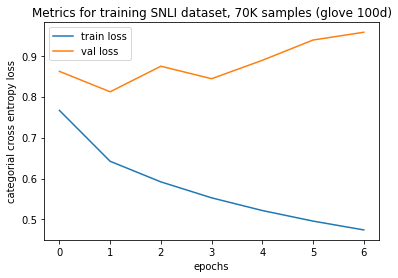

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
x = np.arange(len(history.history['loss']))
ax.plot(x, history.history['loss'], label="train loss")
ax.plot(x, history.history['val_loss'], label="val loss")
plt.xlabel("epochs")
plt.ylabel("categorial cross entropy loss")
ax.legend()
plt.title("Metrics for training SNLI dataset, 70K samples (glove 100d)")
#history.history['loss']

#### Model using attention
See example here https://keras.io/api/layers/attention_layers/attention/

In [59]:
# Variable-length int sequences.
query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding lookup.
token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False)
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)
# Value embeddings of shape [batch_size, Tv, dimension].
value_embeddings = token_embedding(value_input)

# CNN layer.
# cnn_layer = tf.keras.layers.Conv1D(
#     filters=100,
#     kernel_size=4,
#     # Use 'same' padding so outputs have the same shape as inputs.
#     padding='same')
# Query encoding of shape [batch_size, Tq, filters].
# query_seq_encoding = cnn_layer(query_embeddings)
# # Value encoding of shape [batch_size, Tv, filters].
# value_seq_encoding = cnn_layer(value_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
# query_value_attention_seq = tf.keras.layers.Attention()(
#     [query_seq_encoding, value_seq_encoding])

query_value_attention_seq = tf.keras.layers.Attention()(
    [query_embeddings, value_embeddings])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
    query_embeddings)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
    query_value_attention_seq)

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = tf.keras.layers.Concatenate()(
    [query_encoding, query_value_attention])

# input_layer = tf.keras.layers.Concatenate()(
#     [query_embeddings, query_value_attention_seq])

x1 = tf.keras.layers.Dense(16, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(input_layer)
x2 = tf.keras.layers.Dropout(0.3)(x1)
output = tf.keras.layers.Dense(3, activation='softmax')(x2)
model = keras.Model(inputs=[query_input, value_input], outputs=output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 100)    800100      input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
attention_6 (Attention)         (None, None, 100)    0           embedding_8[0][0]          

In [50]:
!mkdir -p tmp/attention/

In [60]:
checkpoint_filepath = 'tmp/attention/checkpoint_fever_rte'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [61]:
history = model.fit(dataset, epochs = 12, validation_data=dataset_dev, callbacks=[stop_early, model_checkpoint_callback])

Epoch 1/12
2272/2272 [==============================] - 238s 84ms/step - loss: 0.9525 - accuracy: 0.5943 - val_loss: 1.1095 - val_accuracy: 0.4238
Epoch 2/12
2272/2272 [==============================] - 237s 84ms/step - loss: 0.9127 - accuracy: 0.6083 - val_loss: 1.0772 - val_accuracy: 0.4508
Epoch 3/12
2272/2272 [==============================] - 236s 83ms/step - loss: 0.9025 - accuracy: 0.6120 - val_loss: 1.0692 - val_accuracy: 0.4495
Epoch 4/12
2272/2272 [==============================] - 236s 83ms/step - loss: 0.8955 - accuracy: 0.6156 - val_loss: 1.0526 - val_accuracy: 0.4726
Epoch 5/12
2272/2272 [==============================] - 235s 83ms/step - loss: 0.8906 - accuracy: 0.6188 - val_loss: 1.0667 - val_accuracy: 0.4575
Epoch 6/12
2272/2272 [==============================] - 238s 84ms/step - loss: 0.8859 - accuracy: 0.6219 - val_loss: 1.0521 - val_accuracy: 0.4606
Epoch 7/12
2272/2272 [==============================] - 238s 84ms/step - loss: 0.8844 - accuracy: 0.6221 - val_loss: 1

In [53]:
!pip list | grep tensorflow

tensorflow                         2.5.0
tensorflow-datasets                4.3.0
tensorflow-estimator               2.5.0
tensorflow-gpu                     2.5.0
tensorflow-hub                     0.12.0
tensorflow-metadata                1.1.0
tensorflow-serving-api             2.4.1
tensorflow-text                    2.5.0
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.


In [54]:
!pip list | grep cudn

You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.


#### BiLSTM with attention

In [322]:
### Simple model
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import *

vocab_size= 8000
dim = 300
inp1 = keras.Input(shape=(None, ), name = "hypothesis")
inp2 = keras.Input(shape=(None, ), name = "evidence")

embedding_hyp_layer = Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False)
embedding_evi_layer = Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False)


x_hyp = embedding_hyp_layer(inp1)
x_hyp = tf.keras.layers.Dropout(0.5)(x_hyp)

x_evi = embedding_evi_layer(inp2)
x_evi = tf.keras.layers.Dropout(0.5)(x_evi)

#Encoder = Bidirectional(CuDNNLSTM(units=300, return_sequences=True, kernel_initializer='RandomNormal'))

lstm_layer1 = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim), return_sequences=True))(x_hyp)

lstm_layer2 = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim), return_sequences=True))(x_evi)

# lstm_layer1 = Encoder(x_hyp)
# lstm_layer2 = Encoder(x_evi)

F_p, F_h = lstm_layer1, lstm_layer2
Eph = keras.layers.Dot(axes=(2, 2))([F_h, F_p])  # [batch_size, Hsize, Psize]
Eh = Lambda(lambda x: keras.activations.softmax(x))(Eph)  # [batch_size, Hsize, Psize]
Ep = keras.layers.Permute((2, 1))(Eph)  # [batch_size, Psize, Hsize)
Ep = Lambda(lambda x: keras.activations.softmax(x))(Ep)  # [batch_size, Psize, Hsize]
    
    
    
# 4, Normalize score matrix, encoder premesis and get alignment
PremAlign = keras.layers.Dot((2, 1))([Ep, lstm_layer2]) # [-1, Psize, dim]
HypoAlign = keras.layers.Dot((2, 1))([Eh, lstm_layer1]) # [-1, Hsize, dim]
mm_1 = keras.layers.Multiply()([lstm_layer1, PremAlign])
mm_2 = keras.layers.Multiply()([lstm_layer2, HypoAlign])
sb_1 = keras.layers.Subtract()([lstm_layer1, PremAlign])
sb_2 = keras.layers.Subtract()([lstm_layer2, HypoAlign])
    

# concat [a_, a~, a_ * a~, a_ - a~], isto za b_, b~
PremAlign = keras.layers.Concatenate()([lstm_layer1, PremAlign, sb_1, mm_1,])  # [batch_size, Psize, 2*unit]
HypoAlign = keras.layers.Concatenate()([lstm_layer2, HypoAlign, sb_2, mm_2])  # [batch_size, Hsize, 2*unit]

# inputs = tf.keras.Input(shape=(10, 128, 128, 3))
# conv_2d_layer = tf.keras.layers.Conv2D(64, (3, 3))
# outputs = tf.keras.layers.TimeDistributed(conv_2d_layer)(inputs)
# outputs.shape


# ff layer w/RELU activation
Compresser = tf.keras.layers.TimeDistributed(Dense(300,
                                   kernel_regularizer=l2(0.0),
                                   bias_regularizer=l2(0.0),
                                   activation='relu'),
                             name='Compresser')

PremAlign = Compresser(PremAlign)
HypoAlign = Compresser(HypoAlign)
    

# 5, Final biLST < Encoder + Softmax Classifier
# Decoder = Bidirectional(CuDNNLSTM(units=100, return_sequences=True, kernel_initializer='RandomNormal'),
#                         name='finaldecoder')  # [-1,2*units]

Decoder = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim), return_sequences=True), name='finaldecoder')


PremAlign = Dropout(0.5)(PremAlign)
HypoAlign = Dropout(0.5)(HypoAlign)
final_p = Decoder(PremAlign)
final_h = Decoder(HypoAlign)
print(final_p)

AveragePooling = tf.keras.layers.GlobalAveragePooling1D()
MaxPooling = tf.keras.layers.GlobalMaxPooling1D()

# AveragePooling = Lambda(lambda x: K.mean(x, axis=1)) # outs [-1, dim]
# MaxPooling = Lambda(lambda x: K.max(x, axis=1)) # outs [-1, dim]
avg_p = AveragePooling(final_p)
avg_h = AveragePooling(final_h)
max_p = MaxPooling(final_p)
max_h = MaxPooling(final_h)
# concat of avg and max pooling for hypothesis and premise
Final = keras.layers.Concatenate()([avg_p, max_p, avg_h, max_h])
# dropout layer
Final = Dropout(0.5)(Final)
# ff layer w/tanh activation
Final = Dense(100,
              kernel_regularizer=l2(0.0),
              bias_regularizer=l2(0.0),
              name='dense300_',
              activation='tanh')(Final)

# last dropout factor
factor = 1
# if self.LastDropoutHalf:
#     factor = 2
Final = Dropout(0.5 / factor)(Final)

# softmax classifier
Final = Dense(3,
              activation='softmax',
              name='judge300_')(Final)
model = tf.keras.Model(inputs=[inp1, inp2], outputs=Final)

LearningRate = 4e-4
GradientClipping = 10.0

# Optimizer = keras.optimizers.Adam(lr = LearningRate,
#             clipnorm = GradientClipping)

model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

model.summary()
# lstm_layer1 = Encoder(x_hyp)
# lstm_layer2 = Encoder(x_evi)

# query_value_attention_seq = tf.keras.layers.Attention()(
#     [lstm_layer1, lstm_layer2])

# query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
#     lstm_layer1)
# query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
#     query_value_attention_seq)

# w = keras.layers.concatenate([query_encoding, query_value_attention], axis = 1)
# x1 = tf.keras.layers.Dense(16, activation='relu')(w)
# x2 = tf.keras.layers.Dropout(0.3)(x1)
# output = tf.keras.layers.Dense(3, activation='softmax')(x2)
# model = keras.Model(inputs=[inp1, inp2], outputs=output)
# model.compile(loss='categorical_crossentropy',
#           optimizer=tf.keras.optimizers.Adam(),
#           metrics=['accuracy'])
# model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, None, 600), dtype=tf.float32, name=None), name='finaldecoder/concat:0', description="created by layer 'finaldecoder'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hypothesis (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
evidence (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    2400300     hypothesis[0][0]                 
__________________________________________________________________________________________________
embedding_1 (Embedding)     

In [58]:
# !rm -rf tmp/attention_esim
# !mkdir -p tmp/attention_esim

In [324]:
checkpoint_filepath = 'tmp/attention_esim/checkpoint_fever_rte_esim'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [59]:
# from tensorflow.python.framework.ops import enable_eager_execution
# enable_eager_execution()
for d in dataset.take(1):
    break

In [60]:
history = model.fit(dataset, epochs = 30, validation_data=dataset_dev, callbacks=[stop_early, model_checkpoint_callback])

Epoch 1/30
2272/2272 [==============================] - 910s 378ms/step - loss: 0.6711 - accuracy: 0.7257 - val_loss: 0.6834 - val_accuracy: 0.6818
Epoch 2/30
2272/2272 [==============================] - 904s 378ms/step - loss: 0.5301 - accuracy: 0.7929 - val_loss: 0.6262 - val_accuracy: 0.7245
Epoch 3/30
2272/2272 [==============================] - 906s 378ms/step - loss: 0.4694 - accuracy: 0.8187 - val_loss: 0.5950 - val_accuracy: 0.7469
Epoch 4/30
2272/2272 [==============================] - 906s 378ms/step - loss: 0.4280 - accuracy: 0.8364 - val_loss: 0.6032 - val_accuracy: 0.7544
Epoch 5/30
2272/2272 [==============================] - 906s 378ms/step - loss: 0.4004 - accuracy: 0.8495 - val_loss: 0.5533 - val_accuracy: 0.7767
Epoch 6/30
2272/2272 [==============================] - 903s 377ms/step - loss: 0.3762 - accuracy: 0.8589 - val_loss: 0.5466 - val_accuracy: 0.7781
Epoch 7/30
2272/2272 [==============================] - 906s 378ms/step - loss: 0.3611 - accuracy: 0.8647 - val_

Text(0.5, 1.0, 'Metrics for training FEVER dataset, 145K samples (glove 300d) ESIM')

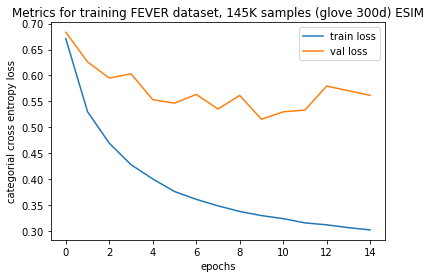

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
x = np.arange(len(history.history['loss']))
ax.plot(x, history.history['loss'], label="train loss")
ax.plot(x, history.history['val_loss'], label="val loss")
plt.xlabel("epochs")
plt.ylabel("categorial cross entropy loss")
ax.legend()
plt.title("Metrics for training FEVER dataset, 145K samples (glove 100d) ESIM")
#history.history['loss']

In [325]:
model.load_weights(checkpoint_filepath)
model.evaluate(dataset_dev)

156/156 [==============================] - 28s 69ms/step - loss: 0.5466 - accuracy: 0.8043


[0.5466161370277405, 0.8042868375778198]

#### Test accuracy

In [ ]:
model.load_weights(checkpoint_filepath)
model.evaluate(dataset_test)

In [158]:
ds_y = dataset_test.map(lambda f, l: l)
ds_y

<MapDataset shapes: (64, 3), types: tf.int32>

In [176]:
y_test_onehot = []
for d in ds_y.batch(1):
    for d1 in d:
        y_test_onehot.append(d1.numpy())

In [186]:
y_test = np.array([np.argmax(a, axis=1) for a in y_test_onehot]).flatten()

In [187]:
y_test

array([0, 0, 2, ..., 0, 0, 2])

In [110]:
y_pred = model.predict(dataset_test)

In [149]:
y_pred_bool = np.argmax(y_pred, axis = 1)

In [153]:
y_pred_bool

array([0, 0, 2, ..., 0, 0, 2])

In [188]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bool))
#['NOT ENOUGH INFO', 'REFUTES', 'SUPPORTS'] == [0, 1, 2]

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      3325
           1       0.85      0.65      0.74      3331
           2       0.70      0.90      0.78      3328

    accuracy                           0.80      9984
   macro avg       0.82      0.80      0.80      9984
weighted avg       0.82      0.80      0.80      9984



### The PIPELINE setting

### Compute FEVER score

#### Using keras tokenizer

In [137]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [139]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None,
    document_count=0
)

In [144]:
for d in ds.take(1):
    print(d)

tf.Tensor(
[b'[START] the dayton agreement was signed in april . [END] The General Framework Agreement for Peace in Bosnia and Herzegovina , also known as the Dayton Agreement , Dayton Accords , Paris Protocol or Dayton-Paris Agreement , is the peace agreement reached at Wright-Patterson Air Force Base near Dayton , Ohio , United States , in November 1995 , and formally signed in Paris on 14 December 1995 . These accords put an end to the - year-long Bosnian War , one of the Yugoslav Wars . '
 b"[START] heinrich himmler was an overseer . [END] Heinrich Luitpold Himmler -LRB- -LSB- \xcb\x88ha\xc9\xaan\xca\x81\xc9\xaa\xc3\xa7 \xcb\x88lu\xcb\x91\xc9\xaat\xcb\x8cp\xc9\x94lt \xcb\x88h\xc9\xaaml\xc9\x90 -RSB- ; 7 October 1900 -- 23 May 1945 -RRB- was Reichsf\xc3\xbchrer of the Schutzstaffel -LRB- Protection Squadron ; SS -RRB- , and a leading member of the Nazi Party -LRB- NSDAP -RRB- of Germany . Nazi leader Adolf Hitler briefly appointed him a military commander and later Commander of the 

In [143]:
tokenizer.fit_on_texts(ds)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'lower'

##### ESIM Model
https://github.com/dzdrav/kerasESIM/blob/master/tfRNN.py

In [206]:
def create_enhanced_attention_model(self):
    # 0, (Optional) Set the upper limit of GPU memory
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

    # 1, Embedding the input and project the embeddings
    premise = Input(shape=(self.SentMaxLen,), dtype='int32')
    hypothesis = Input(shape=(self.SentMaxLen,), dtype='int32')
    embed_p = self.Embed(premise)  # [batchsize, Psize, Embedsize]
    embed_h = self.Embed(hypothesis)  # [batchsize, Hsize, Embedsize]

    # 2, Encoder words with its surrounding context
    # initialization of LSTM input matrix with random Gauss distr
    Encoder = Bidirectional(CuDNNLSTM(units=300, return_sequences=True, kernel_initializer='RandomNormal')) # nova linija - CuDNNLSTM

    embed_p = Dropout(self.DropProb)(embed_p) # firstly dropout
    embed_h = Dropout(self.DropProb)(embed_h) # firstly dropout
    embed_p = Encoder(embed_p) # then BiLSTM encoding
    embed_h = Encoder(embed_h) # then BiLSTM encoding

    # 2, Score each words and calc score matrix Eph.
    F_p, F_h = embed_p, embed_h
    Eph = keras.layers.Dot(axes=(2, 2))([F_h, F_p])  # [batch_size, Hsize, Psize]
    Eh = Lambda(lambda x: keras.activations.softmax(x))(Eph)  # [batch_size, Hsize, Psize]
    Ep = keras.layers.Permute((2, 1))(Eph)  # [batch_size, Psize, Hsize)
    Ep = Lambda(lambda x: keras.activations.softmax(x))(Ep)  # [batch_size, Psize, Hsize]

    # 4, Normalize score matrix, encoder premesis and get alignment
    PremAlign = keras.layers.Dot((2, 1))([Ep, embed_h]) # [-1, Psize, dim]
    HypoAlign = keras.layers.Dot((2, 1))([Eh, embed_p]) # [-1, Hsize, dim]
    mm_1 = keras.layers.Multiply()([embed_p, PremAlign])
    mm_2 = keras.layers.Multiply()([embed_h, HypoAlign])
    sb_1 = keras.layers.Subtract()([embed_p, PremAlign])
    sb_2 = keras.layers.Subtract()([embed_h, HypoAlign])

    # concat [a_, a~, a_ * a~, a_ - a~], isto za b_, b~
    PremAlign = keras.layers.Concatenate()([embed_p, PremAlign, sb_1, mm_1,])  # [batch_size, Psize, 2*unit]
    HypoAlign = keras.layers.Concatenate()([embed_h, HypoAlign, sb_2, mm_2])  # [batch_size, Hsize, 2*unit]
    # ff layer w/RELU activation
    Compresser = TimeDistributed(Dense(300,
                                       kernel_regularizer=l2(self.L2Strength),
                                       bias_regularizer=l2(self.L2Strength),
                                       activation='relu'),
                                 name='Compresser')
    PremAlign = Compresser(PremAlign)
    HypoAlign = Compresser(HypoAlign)

    # 5, Final biLST < Encoder + Softmax Classifier
    Decoder = Bidirectional(CuDNNLSTM(units=300, return_sequences=True, kernel_initializer='RandomNormal'),
                            name='finaldecoder')  # [-1,2*units]
    PremAlign = Dropout(self.DropProb)(PremAlign)
    HypoAlign = Dropout(self.DropProb)(HypoAlign)
    final_p = Decoder(PremAlign)
    final_h = Decoder(HypoAlign)

    AveragePooling = Lambda(lambda x: K.mean(x, axis=1)) # outs [-1, dim]
    MaxPooling = Lambda(lambda x: K.max(x, axis=1)) # outs [-1, dim]
    avg_p = AveragePooling(final_p)
    avg_h = AveragePooling(final_h)
    max_p = MaxPooling(final_p)
    max_h = MaxPooling(final_h)
    # concat of avg and max pooling for hypothesis and premise
    Final = keras.layers.Concatenate()([avg_p, max_p, avg_h, max_h])
    # dropout layer
    Final = Dropout(self.DropProb)(Final)
    # ff layer w/tanh activation
    Final = Dense(300,
                  kernel_regularizer=l2(self.L2Strength),
                  bias_regularizer=l2(self.L2Strength),
                  name='dense300_' + self.dataset,
                  activation='tanh')(Final)

    # last dropout factor
    factor = 1
    if self.LastDropoutHalf:
        factor = 2
    Final = Dropout(self.DropProb / factor)(Final)

    # softmax classifier
    Final = Dense(2 if self.dataset == 'rte' else 3,
                  activation='softmax',
                  name='judge300_' + self.dataset)(Final)
    self.model = Model(inputs=[premise, hypothesis], outputs=Final)